# Analyse de reconnaissance des entités nommées des personnes dans le corpus

## Imports

In [1]:
from collections import defaultdict

import sys
import spacy
from spacy.lang.fr.examples import sentences

## For stop words 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from os import listdir
from os.path import join, isfile

import nltk
from thefuzz import fuzz
from thefuzz import process
from Levenshtein import distance

import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Ensemble de données choisi pour l'analyse

### Choisir et filtrer les fichiers du corpus

In [6]:
#%%time

#people = defaultdict(int)

dirname = '../data/txt'

# Choisir les années
# 1939 parce-que 1940 il n'y a pas
years = ['1850', '1860', '1870', '1880', '1890', '1900', '1910', '1920', '1930', '1939', '1940', '1950', '1960', '1970']

#Filtrer les années
def in_year(x):
    for year in years:
        if year in x:
            return True
    return False

#Liste des fichiers faisant partie des années filtrées avec filter()
files = list(filter(in_year, [f for f in listdir(dirname) if isfile(join(dirname, f))]))

print(files[:10])
    

['Bxl_1850_Tome_I1_Part_1.txt', 'Bxl_1850_Tome_I1_Part_2.txt', 'Bxl_1850_Tome_I1_Part_3.txt', 'Bxl_1850_Tome_I1_Part_4.txt', 'Bxl_1850_Tome_II1_Part_1.txt', 'Bxl_1850_Tome_II1_Part_2.txt', 'Bxl_1850_Tome_II1_Part_3.txt', 'Bxl_1850_Tome_II1_Part_4.txt', 'Bxl_1850_Tome_II1_Part_5.txt', 'Bxl_1850_Tome_II1_Part_6.txt', 'Bxl_1850_Tome_II1_Part_7.txt', 'Bxl_1860_Tome_I1_Part_1.txt', 'Bxl_1860_Tome_I1_Part_2.txt', 'Bxl_1860_Tome_I1_Part_3.txt', 'Bxl_1860_Tome_I1_Part_4.txt', 'Bxl_1860_Tome_II1_Part_1.txt', 'Bxl_1860_Tome_II1_Part_2.txt', 'Bxl_1860_Tome_II1_Part_3.txt', 'Bxl_1860_Tome_II1_Part_4.txt', 'Bxl_1860_Tome_II1_Part_5.txt', 'Bxl_1860_Tome_II1_Part_6.txt', 'Bxl_1870_Tome_I1_Part_1.txt', 'Bxl_1870_Tome_I1_Part_2.txt', 'Bxl_1870_Tome_I1_Part_3.txt', 'Bxl_1870_Tome_I1_Part_4.txt', 'Bxl_1870_Tome_I1_Part_5.txt', 'Bxl_1870_Tome_I1_Part_6.txt', 'Bxl_1870_Tome_II1_Part_1.txt', 'Bxl_1870_Tome_II1_Part_2.txt', 'Bxl_1870_Tome_II1_Part_3.txt', 'Bxl_1870_Tome_II1_Part_4.txt', 'Bxl_1870_Tome_II1_Pa

### Statistiques des fichiers

In [99]:
count_tomes = defaultdict(int)
count_cities = defaultdict(int)
count_files_year = defaultdict(int)

In [100]:
for f in files:
    if "_" in f and f.endswith("txt"):
        elems = f.split("_")
        city = elems[0]
        tome = elems[3]
        files_year = elems[1]
        count_cities[city] += 1
        count_tomes[tome] += 1
        count_files_year[files_year] += 1
    else:
        print(f"Anomalous file: {f}")

In [101]:
nb_rap = count_tomes['RptAn']
print(f"{len(files) - nb_rap} documents sont des bulletins et {nb_rap} documents sont des rapports annuels")

239 documents sont des bulletins et 8 documents sont des rapports annuels


In [102]:
print(f"Il y a {count_cities['Bxl']} bulletins de Bruxelles and {count_cities['Lkn']} de Laeken")

Il y a 242 bulletins de Bruxelles and 5 de Laeken


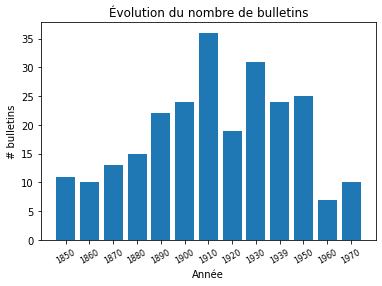

In [103]:
index = np.arange(len(count_files_year))
plt.bar(index, count_files_year.values())
plt.xlabel('Année')
plt.ylabel('# bulletins')
plt.xticks(index, count_files_year.keys(), fontsize=8, rotation=30)
plt.title('Évolution du nombre de bulletins')
plt.show()

## Reconnaissance d'entités nommées 

### Creer une liste de stop words

In [2]:
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", 
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu", "q u i", "Messieurs", "q u '", "D e P", "Page", 
       "Médicamens", "u r r i", "Enraisonde", "o p fa", "D E J", "lle5la", "Dépôt", 
       "É V A L U A T I O N DES T E", "j o u r", "Amortissement", "i v i", "Pardon", "W Y I V S DE",
       "Discussion", "u vernement", "q u ' i", "é t a i", "q u e", "Celte", "Veuillez", "e u r",
       "u i r", "v o i r", "Proposition", "D o u c e t", "i c i", "Subside", "o u i", "u i t", "Carreau",
       "Paiemens", "r i e", "é t a i r", "i t - i l", "o u v r i r", "u j o u r", "Passons", "Voyons",
       "t e r r", "Légumes", "Déjà", "j u g é", "bon v o u", "u t i o", "é d i", "q u i d", "é r e r",
       "contre-avis", "u t i l e", "i v i d u", "reclus", "p o u r", "Recettes", "c. Amortissement",
       "^ Moyennant", "advînt", "Agneessens", "apet", "çenè", "Phospiee", "u i<v", "Voulez", "o u r r",
       "D e H", "P r é", "qucnce", "CHARGES SUR", "Année", "Montant du Sans", "Imputations", "Cercueils",
       "Avances", "Recommander", "u r r", "Layettes", "u s i e u r", "v e i", "u collège", "Prorogation",
       "ldiers", "Interpellation", "Monnaie", "r i r", "pèitl parfahçmenl", "mnrcfcé", "u i v r", "Naguère",
       "hôpital Saint-Jean", "Abordant", "Faudra", "quesais", "v e r", "vcrdui ière", "u p r i x", 
       "Vieux-Marché", "j o u", "Démission", "i q u é", "50 c.", "û t e r", "q u e !", "u r é", "u v r i r",
       "q u i c o", "c i r c u", "v i e r", "RESULTATS DE L'OPERATION AU BOUT DE", "pour24 ans", "soieni",
       "i v i sion", "Décentraliser", "u i q u i", "halle", "loué", "Patriarches", "vdle", "messieurs",
       "auxrenseignemens", "dessein", " Gross", "Fruits", "Cellierss", "a u j o", "270,785 f r",
       "u Marché-aux-Herbes", "payât", "G/10s", "u j o", "q u ' a r r i v e r a - t - i", "u Collège",
       "Tromper", "Distribution", "F. de Page", "u mont-de-piété", "u i v", "v i e r d e r", "mon i",
       "Troplong", "Prétendra", "Pusage", "arB   ", "Contiendra", "eYst", "Comp", "Communication", "î f l",
       "Voté apparait", "embellissemens", "u vestibule d", "naie", "lllaes", "BAR-", "L'auteur", "Paradis",
       "Abonnemens", "Maintenez", "vientde", "Parterre", "S6,000", "couronnas", "vousmêmes", "Reste", "rétendue"]
sw = set(sw)

In [3]:
print(f"{len(sw)} stopwords")

365 stopwords:
 [' Gross', '270,785 f r', '50 c.', 'Abonnemens', 'Abordant', 'Agneessens', 'Amortissement', 'Année', 'Avances', 'BAR-', 'CHARGES SUR', 'Carreau', 'Cellierss', 'Celte', 'Cercueils', 'Communication', 'Comp', 'Contiendra', 'D E J', 'D e H', 'D e P', 'D o u c e t', 'Discussion', 'Distribution', 'Décentraliser', 'Déjà', 'Démission', 'Dépôt', 'Enraisonde', 'F. de Page', 'Faudra', 'Fruits', 'G/10s', 'Imputations', 'Interpellation', "L'auteur", 'Layettes', 'Légumes', 'Maintenez', 'Messieurs', 'Monnaie', 'Montant du Sans', 'Médicamens', 'Naguère', 'P r é', 'Page', 'Paiemens', 'Paradis', 'Pardon', 'Parterre', 'Passons', 'Patriarches', 'Phospiee', 'Proposition', 'Prorogation', 'Prétendra', 'Pusage', "RESULTATS DE L'OPERATION AU BOUT DE", 'Recettes', 'Recommander', 'Reste', 'S6,000', 'Subside', 'Tromper', 'Troplong', 'Veuillez', 'Vieux-Marché', 'Voté apparait', 'Voulez', 'Voyons', 'W Y I V S DE', '^ Moyennant', 'a u j o', 'advînt', 'ai', 'aie', 'aient', 'aies', 'ainsi', 'ait', 'ape

### Appliquer la reconnaissance d'entités nommées PER

In [5]:
#%%time
people = defaultdict(int)

nlp = spacy.load('fr_core_news_md')

In [ ]:
%%time

for file in files:
    path = join(dirname, file)
    print('path', path)
    with open(path, encoding='utf-8') as f:
        text = f.read()
        #print('file read')
        doc = nlp(text)
        for ent in doc.ents:
            if ent.label_ == "PER" and len(ent.text) > 3 and ent.text not in sw:
                people[ent.text] += 1
                

In [64]:
# Nombre d'entités trouvées
len(people.keys())

42775

## Détection d'erreurs d'OCR dans la reconnaissance d'entités nommées

### Détection non automatique d'erreurs OCR

In [62]:

sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)

# Trouver mots -> entités qui sont du style 'e t a', 'a l ^', 'o u a l'
def is_not_ocr_error(word):
    for w in word.split(" "):
        if len(w) > 1:
            return True

    return False

# Filtrer les mots sans l'erreur d'OCR trouvé
sorted_people = list(filter(lambda x: is_not_ocr_error(x[0]), sorted_people[:100]))

#map fonction pour detecter le 1er element de la tuple
names = list(map(lambda x: x[0], sorted_people))
repeated = defaultdict(list)


KeyboardInterrupt: 

### Détection automatique d'erreurs OCR et regrouper les entités selon la similarité

In [ ]:
# Lister/grouper les mots considérés comme synonymes = fuzz.ratio > 75 
for name in names:
    repeated[name] = list()
    for other_name in names:
        if name != other_name:
            ratio = fuzz.ratio(name, other_name)
            # 75 Ç'est un bon numéro de manière général, sauf pour le mot "Bourgmestre"
            if ratio >= 75: 
                repeated[name].append(other_name)
            

print(repeated[:100])

## Nettoyage des entités trouvées 

### Déduplication de groupe d'entités similaires

In [61]:
# Garder un set()  avec les mots déjà traités pour ne pas les traiter plus d'une fois
processed = set() 

# Sommer la frequence d'un mot et ses synonymes
dedup = {} 

# Traiter 
for word, synonyms in repeated.items():
    # Si un mot n'a pas été traité
    if (word not in processed and word != "Bourgmestre"): # hack
        dedup[word] = next(x for x in sorted_people if x[0] == word)[1]
        
        processed.add(word)
        for w in synonyms:
            e = next(x for x in sorted_people if x[0] == w)[1]
            dedup[word] += e
            processed.add(w)

print(dedup[:50])

#len(dedup.keys())
    

{'M. le Bourgmestre': 6557, 'Mesdames': 1736, 'Echevin': 2013, 'Brunfaut': 1280, 'Lepage': 1124, 'Richald': 907, 'Budget': 733, 'Bochart': 847, 'Vermeire': 835, 'De Mot': 713, 'Considérant': 530, 'Speeckaert': 416, 'Secrétaire': 959, 'Vauthier': 430, "M. l'Echevin": 1087, 'Catteau': 475, 'Lemonnier': 410, 'Godefroy': 551, 'Verheven': 434, 'Camille Huysmans': 361, 'Depaire': 464, 'Hubert': 431, 'Foucart': 303, 'Montant': 315, 'Bauwens': 362, 'Fabrique': 314, 'Deboeck': 402, 'Président': 366, 'Joseph': 374, 'Legs': 272, 'Thonet': 246, 'Observations': 327, 'Moyson': 222, 'Loyer': 253, 'Conrardy': 243, 'Linotte': 246, 'Vandendorpe': 286, 'Jean': 379, 'Schmitz': 276, 'Louise': 364, 'Lalemand': 273, 'Bischoffsheim': 366, 'Adoption': 199, 'Schalckens': 205, 'Propriétés': 194, 'Fontainas': 278, 'Entretien': 197, 'Anspach': 231, 'Theodor': 212, 'Monsieur': 244, 'Piron': 229, 'M. Durant': 251, 'Brugmann': 252, 'Hallet': 222, 'Anspach-Puissant': 189, 'Penaranda de Franchimont': 223, 'Gudule': 164